In [1]:
#Loading in libraries
pacman::p_load(tidyverse, dplyr, ggplot2, corrplot,
               repr, BBmisc, devtools, reticulate, Rcpp, tictoc, Metrics)

#Loading in data
data <- read.csv("../input/tabular-playground-series-jun-2022/data.csv")

In [2]:
#Loading in h2o4gpu package
devtools::install_github("h2oai/h2o4gpu", subdir = "src/interface_r")
library(h2o4gpu)


'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/cub /tmp/RtmpEZQuLg/remotese46121aa5/h2oai-h2o4gpu-aaf7795/src/interface_r/../../cub

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/xgboost /tmp/RtmpEZQuLg/remotese46121aa5/h2oai-h2o4gpu-aaf7795/src/interface_r/../../xgboost

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/py3nvml /tmp/RtmpEZQuLg/remotese46121aa5/h2oai-h2o4gpu-aaf7795/src/interface_r/../../py3nvml

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/h2oai/scikit-learn.git /tmp/RtmpEZQuLg/remotese46121aa5/h2oai-h2o4gpu-aaf7795/src/interface_r/../../scikit-learn

'/usr/bin/git' clone --depth 1 --no-hardlinks --recurse-submodules https://github.com/google/googletest.git /tmp/RtmpEZQuLg/remotese46121aa5/h2oai-h2o4gpu-aaf7795/src/interface_r/../../tests/googletest

'/usr/bin/git' clone --depth 1 --no-hardlinks 

rprojroot  (2.0.2 -> 2.0.3  ) [CRAN]
Rcpp       (1.0.7 -> 1.0.8.3) [CRAN]
withr      (2.4.2 -> 2.5.0  ) [CRAN]
jsonlite   (1.7.2 -> 1.8.0  ) [CRAN]
RcppTOML   (NA    -> 0.1.7  ) [CRAN]
reticulate (1.22  -> 1.25   ) [CRAN]
magrittr   (2.0.1 -> 2.0.3  ) [CRAN]


Installing 7 packages: rprojroot, Rcpp, withr, jsonlite, RcppTOML, reticulate, magrittr

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘Rcpp’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘jsonlite’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘magrittr’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmpEZQuLg/remotese46121aa5/h2oai-h2o4gpu-aaf7795/src/interface_r/DESCRIPTION’
─  preparing ‘h2o4gpu’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘h2o4gpu_0.3.3.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘h2o4gpu’


The following object is masked from ‘package:base’:

    transform




In [3]:
#Installing python module for h2o4gpu
py_install("h2o4gpu",
          pip = TRUE)

# How much is missing?

In [4]:
#Removing row_id
data <- data[, -1]

#Number of missing rows
     cat(sprintf("Number of missing rows: %s\n", sum(is.na(data))))

Number of missing rows: 1000000


In [5]:
missing_features <- c()

for(i in 1:length(data)) {
    missing_features[i] <- sum(is.na(data[, i]))
}

missing_features <- missing_features[-c(16:40)]

missing_data <- data.frame(feature = colnames(data)[c(1:15, 41:length(data))], rows_missing = missing_features)


t(missing_data)

cat(sprintf("Mean of missing rows: %s\n", mean(missing_features)))
cat(sprintf("Standard deviation of missing rows: %s\n", sd(missing_features)))

feature,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,⋯,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
rows_missing,18397,18216,18008,18250,18322,18089,18133,18128,18162,18249,⋯,18063,18325,18014,18176,18265,18225,18119,18306,17995,18267


Mean of missing rows: 18181.8181818182
Standard deviation of missing rows: 126.863018997758


Features from 17 to 41 have no missing rows. Rest of features are missing around 18180 rows each, with very slight variation. 

In [6]:
#Percentage of data missing (excluding columns that have no missing values)
     cat(sprintf("Percentage of data missing: %s\n", 100/(length(data)-length(c(16:40)))))

Percentage of data missing: 1.81818181818182


Almost 2% of rows are missing.

Missing elements will play out a huge part in properly predicting selected features.

**Corrplot**

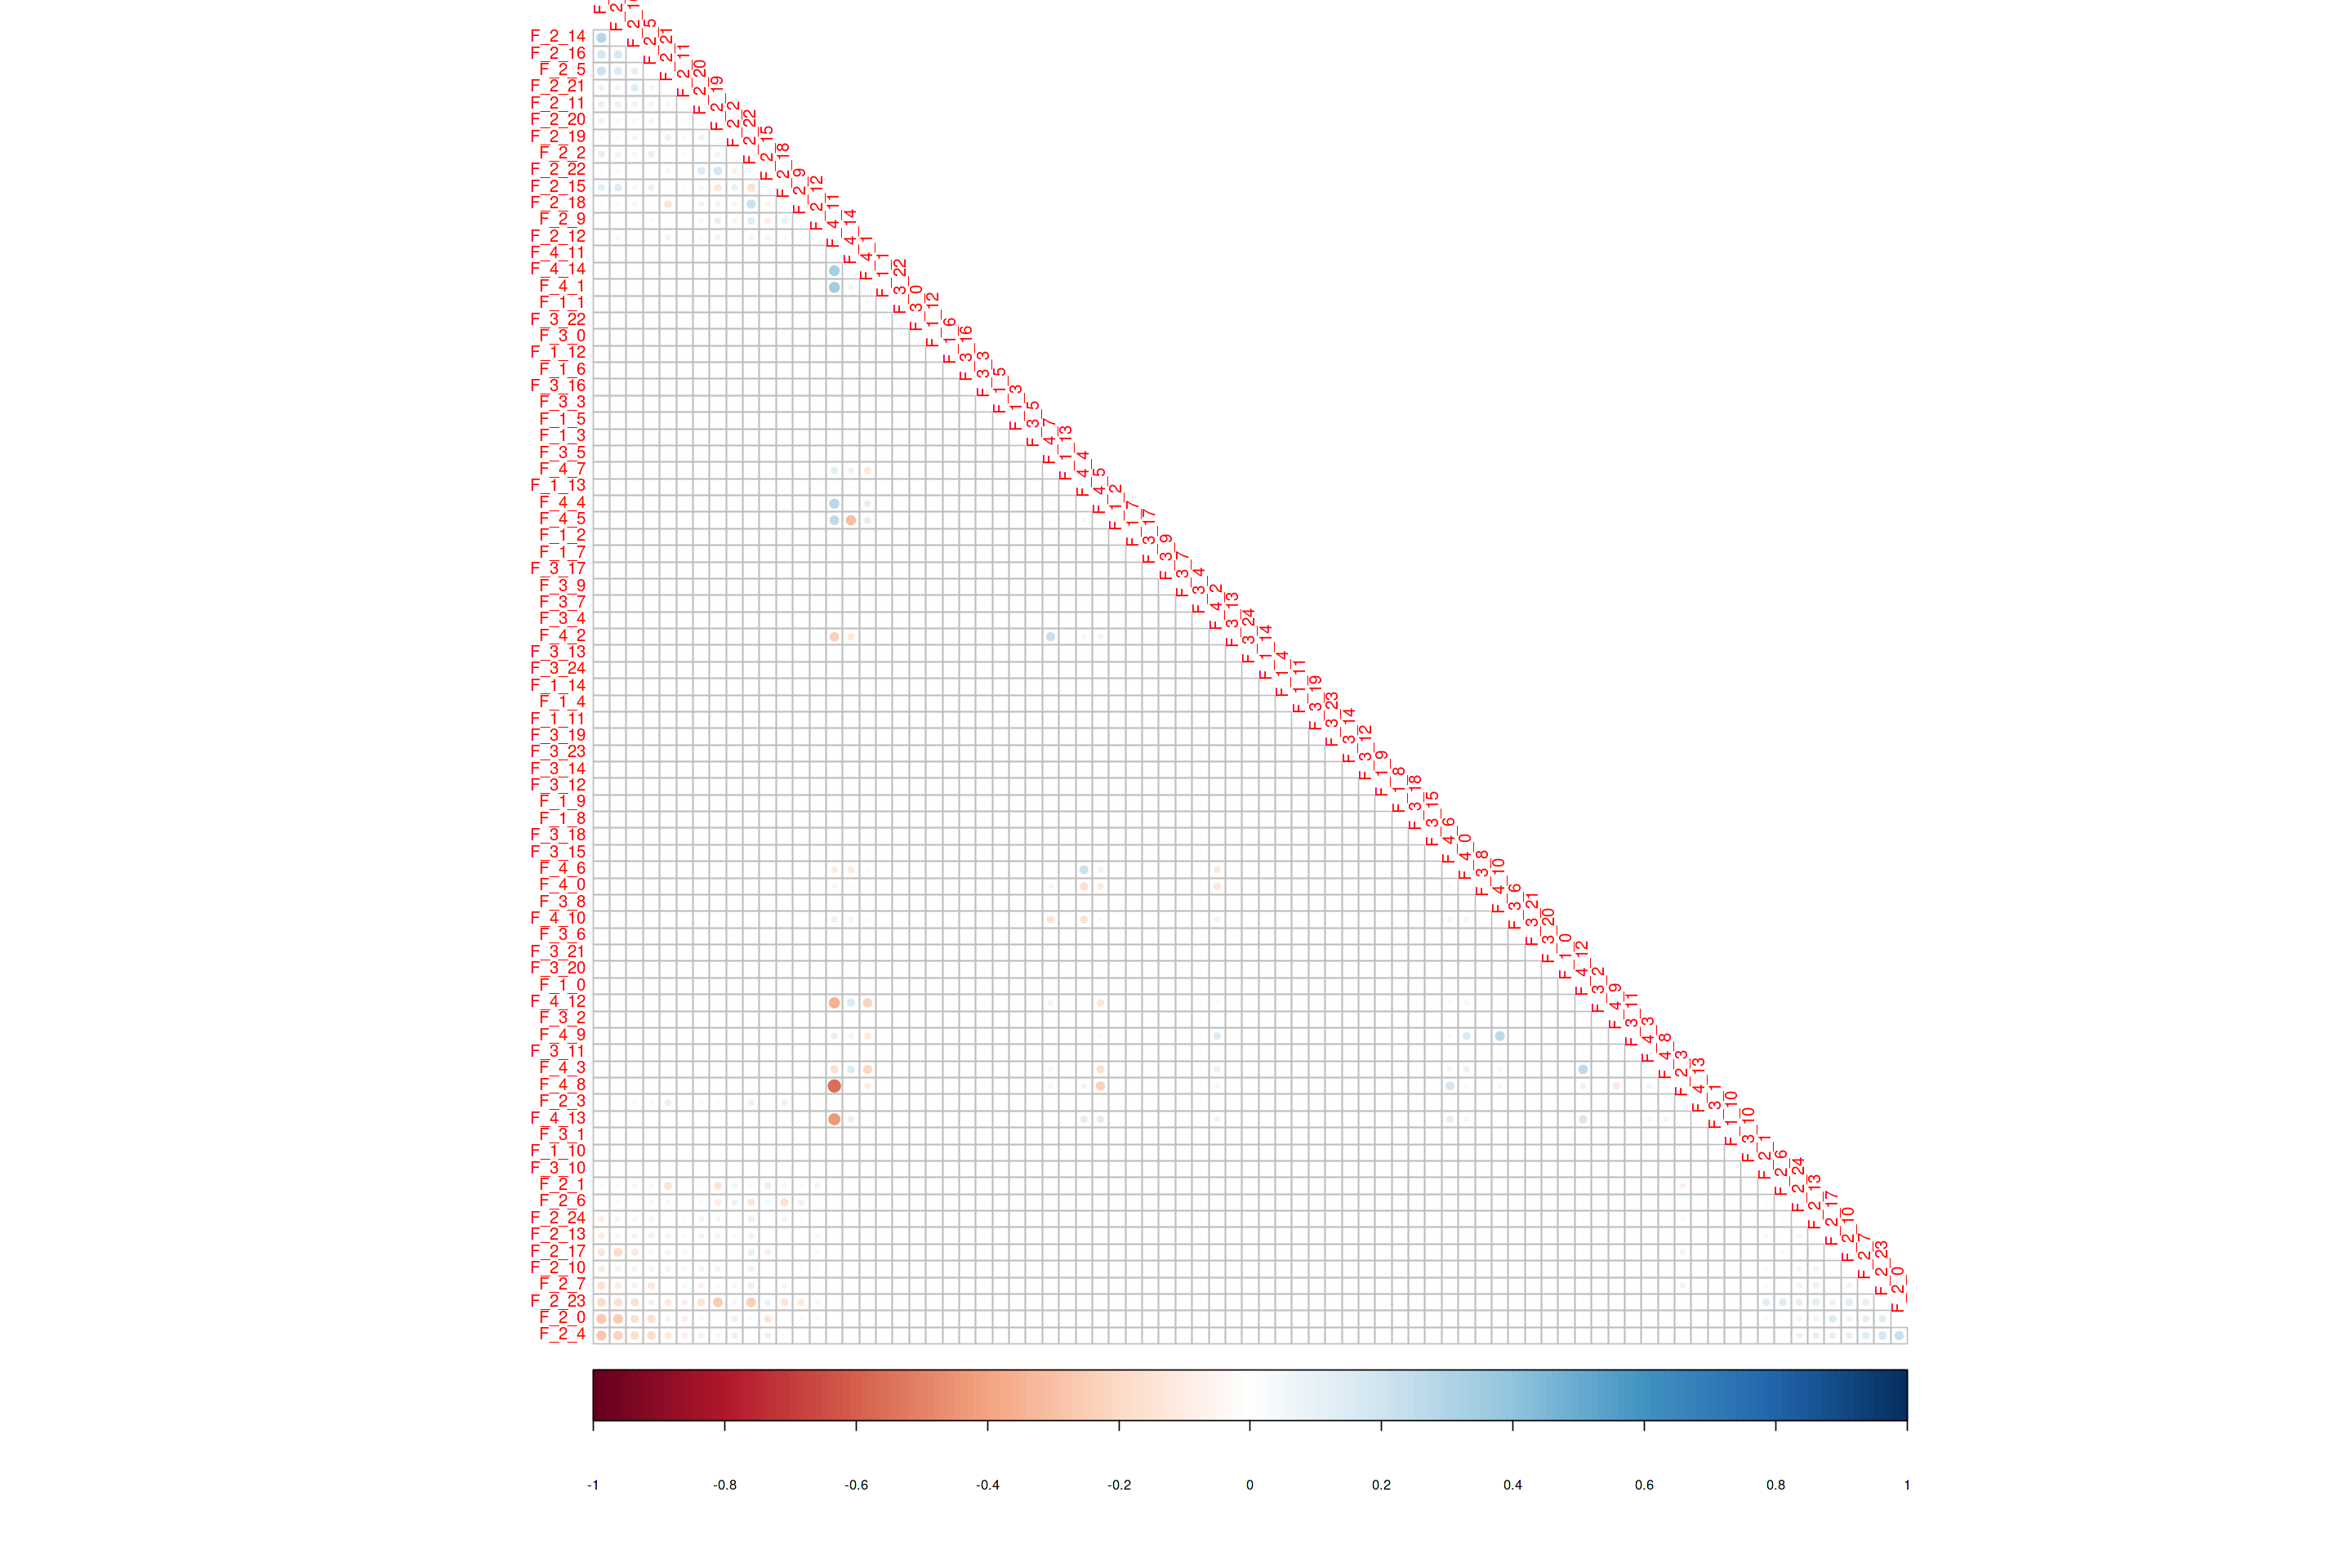

In [7]:
clean_data <- na.omit(data)


options(repr.plot.width = 24, repr.plot.height = 16)
clean_data <- clean_data %>%
    cor() %>%
    corrplot(method = "circle", order = 'FPC', type = 'lower', diag = FALSE)

According to the plot feature *F_4_11* has the highest correlations. With these many features plotting may not be the most pleasant visual representation.

# Finding parameters

**'Clean' data - preliminary grid search**

Running features through different parameters, using only rows with no missing values (0.3 of the original dataset). Previous runs showcased the existance of 'groups' - some features share similar hyperparameter tendencies whilst aiming for the lowest rmse. I'll focus on the number of trees and max depth of the gb model. To simplify, let the values of these parameters be ordinal: low, medium and high.

**Tendencies**
* Low number of trees: 1,2,4,5,6,7,9,10,11,13:15,41:54,56:62,64,65
* Medium number of trees: 3,8,12
* High number of trees: 55,63,66:80

* Low max depth: 1,2,3,4,5,6,7,8,9,11:15,41,42,45:47,49:55,57:65
* Medium max depth: 10,43,44,48,56
* High max depth: 66:80

One distinct group that shares the preference for max depth and higher number of trees consists of features from 66 to 80.


Because we are predicting on the 'training set', to achieve better results, each feature can have its own grid searched parameter values.



**Whole dataset gridsearch**

After predicting using previous hyperparameter assumptions, I'll run the grid search once again on the entirety of the dataset for better accuracy.

**Grid search function**

In [8]:
#dataset = data.frame object, params = list of parameters*, return_n = how many observations should be returned
#target - which column is the target
#k - number of folds; if NULL, k = 50, which_fold - setting a seed to check on the same fold; if NULL, last fold is chosen
#params = depending on model type - list of n parameter arrays, custom holdout - whether to use a custom holdout
h2o4gpu_grid_search <- function(dataset, params, return_n, target, k = NULL, which_fold = NULL) {

#Dataset split
if(missing(k) || (is.null(k))) {
    k_grid <- 50
} else if(!missing(k))
        k_grid <- k



if(missing(which_fold) || (is.null(which_fold))) {
   sampled_k <- k_grid 
} else if(!missing(which_fold))
          sampled_k <- which_fold


holdout_rows <- c(((sampled_k-1)*floor((nrow(dataset)/k_grid))+1):((floor(nrow(dataset)/k_grid))*sampled_k)+nrow(dataset)%%k_grid)


df_grid <- data.frame(learning_rate = 0, n_estimators = 0, max_depth = 0, colsample_bytree = 0, subsample = 0, rmse = 0) 
    

        gb_learning_rate <- params[[1]]
        gb_n_estimators <- params[[2]]
        gb_max_depth <- params[[3]]
        gb_colsample_bytree <- params[[4]]
        gb_subsample <- params[[5]]

    
#Brute grid search loops
for(i in gb_learning_rate) {
    for(j in gb_n_estimators) {
      for(k in gb_max_depth) {
        for(l in gb_colsample_bytree){
          for(n in gb_subsample) {
        
    gb_model_reg <- h2o4gpu.gradient_boosting_regressor(loss = "ls", learning_rate = i,
                    n_estimators = j, subsample = n, criterion = "friedman_mse",
                    min_samples_split = 2L, min_samples_leaf = 1L,
                    min_weight_fraction_leaf = 0, max_depth = k, random_state = 1212,
                    max_features = "auto", presort = "auto",
                    colsample_bytree = l,  tree_method = "gpu_hist",
                    n_gpus = -1L, predictor = "gpu_predictor", objective = "reg:linear",
                    booster = "gbtree",
                    missing = NULL, backend = "h2o4gpu") %>% fit(as.data.frame(dataset[-holdout_rows, -target]), dataset[-holdout_rows, target])
              
        df_grid <- df_grid %>%
          rbind(c(i,j,k,l, n, rmse(predict(gb_model_reg,
                                   as.data.frame(dataset[holdout_rows, -target])),
                                   dataset[holdout_rows, target])))
        
                                  }
                                 }
                                }
                               }
                              }
#Arranging by AUC
    df_grid <- df_grid %>%
        arrange(rmse)


#Removing an empty row
df_grid <- df_grid[-1, ]

df_grid <- df_grid %>%
    head(return_n)

return(df_grid)
}

**Choosing explanatory variables for each feature**

One thing to point out is the notable diffence in model performance based on chosen variables. 

In [9]:
#Model predicting a feature starting with F_3


#Removing rows with missing values
clean_data <- na.omit(data)

gb_params <- list(c(0.05), c(250,400), c(2,4), c(0.75),c(1))

#Predicting F_3_5 feature using all other features
    all_features <- h2o4gpu_grid_search(clean_data, gb_params, return_n = 5, 46, k = 40, which_fold = 10)

#Predicting F_3_5 features using only features starting with F_3
    f_3_features <- h2o4gpu_grid_search(clean_data[, 41:65], gb_params, return_n = 5, 6, k = 40, which_fold = 10)

#Predicting F_3_5 features using only features starting with F_3 and F_2
     f_3_f_2_features <- h2o4gpu_grid_search(clean_data[, 16:65], gb_params, return_n = 5, 31, k = 40, which_fold = 10)


print("Predictions using all features")
print(all_features)
print("Predictions using F_3 features")
print(f_3_features)
print("Predictions using F_3 and F_2 features")
print(f_3_f_2_features)

[1] "Predictions using all features"
  learning_rate n_estimators max_depth colsample_bytree subsample      rmse
2          0.05          250         2             0.75         1 0.9934567
3          0.05          250         4             0.75         1 0.9934706
4          0.05          400         2             0.75         1 0.9935468
5          0.05          400         4             0.75         1 0.9937098
[1] "Predictions using F_3 features"
  learning_rate n_estimators max_depth colsample_bytree subsample      rmse
2          0.05          250         2             0.75         1 0.9934185
3          0.05          400         2             0.75         1 0.9934821
4          0.05          250         4             0.75         1 0.9937717
5          0.05          400         4             0.75         1 0.9941296
[1] "Predictions using F_3 and F_2 features"
  learning_rate n_estimators max_depth colsample_bytree subsample      rmse
2          0.05          250         2       

Choosing specific features results in a slightly better rmse.

To generalize and avoid lengthy sequential addition / removal, I'm checking how first couple of features interact with features selected for them.

Artificial groups are based on the feature names - features starting with F_1, F_2, F_3 and F_4.

In [10]:
#Sampling features from each group
set.seed(7)



**Testing out how 'tendencies' models perform**

In [11]:
#Removing rows with missing values
clean_data <- na.omit(data)



#Creating a list of parameter preferences for features, according to previously established groups

feature_groups <- list(c(1,2,4,5,6,7,9,11,13,14,15,41,42,45,46,47,49,50,51,52,53,54,57,58,59,60,61,62,64,65), #Low max depth, low number of trees
                       c(3,8,12), #Low max depth, medium number of trees
                       c(55,63), #Low max depth, high number of trees
                       c(10,43,44,48,56), #Medium max depth, low trees
                       c(66:80) #High max depth, high trees
                      )

#Parameters reference - learning rate, number of trees, max_depth, colsample by tree, subsample

par_preferences <- list(c(0.05, 250, 2, 0.75, 1), #Low max depth, low number of trees
                        c(0.05, 450, 2, 0.75, 1), #Low max depth, medium number of trees
                        c(0.05, 1400, 2, 1, 1), #Low max depth, high number of trees
                        c(0.05, 250, 4, 0.75, 1), #Medium max depth, low trees
                        c(0.05, 1400, 8, 0.75, 1) #High max depth, high trees
                       )

feature_group_names <- list(c("RMSE mean for low trees / low depth: %s\n"), c("RMSE mean for medium trees / low depth: %s\n"),
                            c("RMSE mean for high trees / low depth: %s\n"), c("RMSE mean for low trees / medium depth: %s\n"),
                            c("RMSE mean for high trees / max depth: %s\n"))


k <- 1
rmse_pred <- c()

for(j in 1:length(par_preferences)) {
    
    tic()
    for(i in feature_groups[[j]]) {
        
        

        rmse_pred[k] <- h2o4gpu_grid_search(clean_data, par_preferences[[j]], return_n = 10, i, k = 40, which_fold = 20)[1, 6]

        k <- k + 1
                }
    
    cat("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n")
    cat(sprintf(feature_group_names[[j]], round(mean(rmse_pred[(k-length(feature_groups[[j]])):(k-1)]),3)))
    
    flush.console() 
    toc()

}



cat("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n")
cat(sprintf("Overall RMSE mean: %s\n", round(mean(rmse_pred),3)))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
RMSE mean for low trees / low depth: 0.964
71.352 sec elapsed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
RMSE mean for medium trees / low depth: 0.902
9.766 sec elapsed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
RMSE mean for high trees / low depth: 0.998
15.068 sec elapsed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
RMSE mean for low trees / medium depth: 1
15.289 sec elapsed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
RMSE mean for high trees / max depth: 0.519
829.473 sec elapsed
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
Overall RMSE mean: 0.844


# Brutish plan

I'll create a faux dataset filled with column means and then use it to predict on the original dataset. Before doing that though, like many noticed, I'll add a row counter of missing features.

In [12]:
#Adding a counter of missing rows
data <- data %>%
    cbind(missing_counter = rowSums(is.na(data)))
    

#Filling missing rows with median value
faux_data <- data

faux_data <- faux_data %>% 
      mutate(across(c(1:length(faux_data)), function(x) ifelse(is.na(x), mean(x, na.rm = T), x)))

**Filling values in the original dataset column by column**

Another possible augment is a stack - predicting each feature with mean values filling missing rows in other columns and then using  those predictions to once again predict each feature.

In [13]:
#Creating a list of parameter preferences for features, according to previously established groups

feature_groups <- list(c(1,2,4,5,6,7,9,11,13,14,15,41,42,45,46,47,49,50,51,52,53,54,57,58,59,60,61,62,64,65), #Low max depth, low number of trees
                       c(3,8,12), #Low max depth, medium number of trees
                       c(55,63), #Low max depth, high number of trees
                       c(10,43,44,48,56), #Medium max depth, low trees
                       c(66:80) #High max depth, high trees
                      )

#Parameters reference - learning rate, number of trees, max_depth, colsample by tree, subsample

par_preferences <- list(c(0.05, 250, 2, 0.75, 1), #Low max depth, low number of trees
                        c(0.05, 400, 2, 0.75, 1), #Low max depth, medium number of trees
                        c(0.05, 1500, 2, 1, 1), #Low max depth, high number of trees
                        c(0.05, 250, 4, 0.75, 1), #Medium max depth, low trees
                        c(0.05, 1500, 8, 0.75, 1) #High max depth, high trees
                       )


predictions_and_indices <- data.frame(predicted_value = 0, which_rows = 0, feature_name = 'blank')

#First model run

for(j in 1:length(par_preferences)) {

    tic()

    for(i in feature_groups[[j]]) {

        faux_data[, i] <- data[, i]

        missing_rows <- which(is.na(data[, i]))
        
 
        gb_imp <- h2o4gpu.gradient_boosting_regressor(loss = "ls", learning_rate = 0.05,
                            n_estimators = par_preferences[[j]][2], subsample = 1, criterion = "friedman_mse",
                            min_samples_split = 2, min_samples_leaf = 1,
                            min_weight_fraction_leaf = 0, max_depth = par_preferences[[j]][3], random_state = 2023,
                            colsample_bytree = par_preferences[[j]][4], num_parallel_tree = 1, tree_method = "gpu_hist",
                            predictor = "gpu_predictor", objective = "reg:linear",
                            booster = "gbtree", n_jobs = 1, gamma = 0,
                            missing = NULL, backend = "h2o4gpu") %>% fit(faux_data[-missing_rows, -i], faux_data[-missing_rows, i])

        
        

        #Predicting missing data in a column
        predict_imp <- predict(gb_imp, faux_data[missing_rows, -i]) 

        faux_data[missing_rows, i] <- predict_imp
        

                }
    
    flush.console() 
    toc()

}

194.374 sec elapsed
25.065 sec elapsed
41.693 sec elapsed
38.481 sec elapsed
1320.148 sec elapsed


**TO DO - Another gridsearch - finding out parameters for the whole dataset**

In this gridsearch each feature has tailored parameters, also using missing rows count as a predictive variable.

**Second model**

In [16]:
#Second model run
for(j in 1:length(par_preferences)) {

    tic()

    for(i in feature_groups[[j]]) {

        faux_data[, i] <- data[, i]

        missing_rows <- which(is.na(data[, i]))
        
 
        gb_imp <- h2o4gpu.gradient_boosting_regressor(loss = "ls", learning_rate = 0.05,
                            n_estimators = par_preferences[[j]][2], subsample = 1, criterion = "friedman_mse",
                            min_samples_split = 2, min_samples_leaf = 1,
                            min_weight_fraction_leaf = 0, max_depth = par_preferences[[j]][3], random_state = 2023,
                            colsample_bytree = par_preferences[[j]][4], num_parallel_tree = 1, tree_method = "gpu_hist",
                            predictor = "gpu_predictor", objective = "reg:linear",
                            booster = "gbtree", n_jobs = 1, gamma = 0,
                            missing = NULL, backend = "h2o4gpu") %>% fit(faux_data[-missing_rows, -i], faux_data[-missing_rows, i])

        
        

        #Predicting missing data in a column
        predict_imp <- predict(gb_imp, faux_data[missing_rows, -i]) 
        

        #Putting the results into a data frame
        temp_df <- data.frame(predicted_value = predict_imp, which_rows = missing_rows)
    
        #Binding grouping variables (feature names)
        temp_df <- temp_df %>%
            cbind(feature_name = rep(colnames(data)[i], length(missing_rows)))
        
        #Binding the temporary data frame to the final one
        predictions_and_indices <- predictions_and_indices %>%
            rbind(temp_df)
        }
    
    flush.console() 
    toc()

}


#Removing first 'empty' row
predictions_and_indices <- predictions_and_indices[-1, ]

201.519 sec elapsed
25.998 sec elapsed
47.289 sec elapsed
41.7 sec elapsed
1543.388 sec elapsed


# Sorting and submitting results

Results are stored in a data frame with predicted values, row indices of those predicted values and their column names.
Sorting by row indices and then by feature / column names results in sorted predicted values, ready for submission.

In [17]:
predictions_and_indices <- predictions_and_indices %>%
 arrange(which_rows, feature_name)

In [18]:
missing_submission <- read.csv("../input/tabular-playground-series-jun-2022/sample_submission.csv")

missing_submission$value <- predictions_and_indices$predicted_value

colnames(missing_submission)[1] <- "row-col"

write.csv(missing_submission, "./missing_sub.csv", quote = FALSE, row.names = FALSE)